In [1]:
import os
import sys

import numpy as np

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec

get_ipython().magic(u'matplotlib inline')

sys.path.append('../3_analyze')
from containers import Dataset
from score_query import ScoreQuery
from utils import export, show_side_by_side, load_score_file

sys.path.append('../1_dock')
from parse_chembl import load_chembl_raw, load_chembl_proc
from core_proc import load_matches

In [4]:
data = '/scratch/PI/rondror/jbelk/method/data'
glide_dir = 'docking/glide12-HALPss'
ifp_dir = 'ifp/ifp-HALPss'

# options: 
#     glide12 (unrestrained docking)
#     glide12-6C38ss (docking of ligands with the risperidone scaffold constrained to the crystal structure)
#     glide12-HALPss (docking of ligands with the haloperidol scaffold constrained to predicted location)

# each glide directory has its own fingerprint directory

CHEMBL54_lig 0.16
CHEMBL297302_lig 0.027
CHEMBL1257688_lig 3.6
CHEMBL1257689_lig 3.4
CHEMBL134400_lig 0.023
CHEMBL137648_lig 0.023
CHEMBL297302_lig 0.027
CHEMBL135917_lig 0.029
CHEMBL135832_lig 0.033


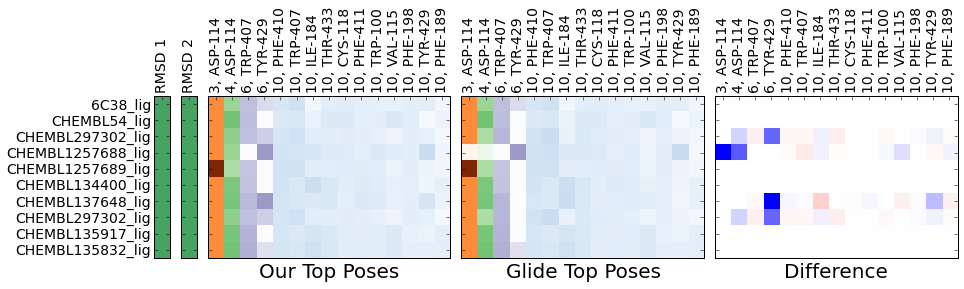

In [5]:
num_ligs = 10
data_const = 0.1
num_poses = 100

# 2: hydrogen bond
# 3: hydrogen bond
# 4: salt bridge
# 6: pipi interaction
# 10: contact
w = {2:1,3:1,4:1,6:1,10:0.005}

prot = 'D2R'
struct = '6C38'

# manually specifying particular ligands to use
# these are getting loaded in separately because they are using a different glide directory
# Dataset is the class that holds all the info about proteins/ligands/etc
conf_ligs = ['CHEMBL32900{}_lig'.format(i) for i in ['08','03','17','06','12']]
d_conf = Dataset(data, [prot], {prot:struct})
d_conf.load_docking('docking/glide12-6C38ss','ifp/ifp-6C38ss')
d_conf.assign_weights(w)

# this is the main data
d = Dataset(data, [prot], {prot:struct})
d.load_docking(glide_dir, ifp_dir)

d.assign_weights(w)

lig_objs = d.all_proteins[prot].docking[glide_dir].ligands

# the most important ligand properties are "stereo" and "ki".
# "stereo" is True if the smiles string fully specified the ligand stereochemistry
# ki is the ki value recorded in chembl. note that the smaller ki values are higher-affinity.
all_ligs = [l for l in lig_objs if l[:6] == 'CHEMBL' and lig_objs[l].stereo]
all_ligs.sort(key = lambda x: lig_objs[x].ki)

# these are crystal structures
true = {'{}_lig'.format(l):lig.poses[0] for l,lig in d.all_proteins[prot].true.items()}

# this is using different sets of ligands to score
for i in range(20):
    
    # these are the ligands I happened to be interested in (54 is haloperidol)
    l_i = ['CHEMBL{}_lig'.format(j) for j in ['54','297302','1257688','1257689']] # 1108
    
    # I tried scoring them against several different sets of other ligands
    l_i += all_ligs[i*5:(i+1)*5]
    
    if len(l_i) == 0: break
        
    lig_info = {}
    
    # this list of ligands defines which ligands to optimize over
    scored_ligs = sorted(true.keys()) + l_i# + sorted(conf_ligs)
    
    # now we need to gather all of the ligand data to pass into the scoring function
    for li in l_i: # use affinity data
        lig_info[li] = lig_objs[li]
        print li, lig_objs[li].ki
    for ltrue in true: # use crystal structures
        lig_info[ltrue] = d.all_proteins[prot].true[ltrue.split('_')[0]]
    for lconf in conf_ligs: # use constrained docking output
        lig_info[lconf] = d_conf.all_proteins[prot].docking['docking/glide12-6C38ss'].ligands[lconf]

    # this finds the top cluster of "scored_ligands"
    sq = ScoreQuery(None, scored_ligs, lig_info, data_const, num_poses, w)
    sq.score_all()

    # all of these "clusters" are maps of lig
    glide_top = {l:lig.poses[0] for l,lig in lig_info.items()}

    show_side_by_side(sq.top_cluster, glide_top, scored_ligs, 
                      t1='Our Top Poses', t2='Glide Top Poses', num_i=15)
    break
    # this will show up in /scratch/PI/rondror/jbelk/method/outputs
    export(data, {l:p for l,p in sq.top_cluster.items() if l in l_i},
           'd2r{}-{}'.format(ifp_dir.split('/')[1],i), prot, 
           struct=struct, verbose=False, glide_dir=glide_dir)
    break